<a href="https://colab.research.google.com/github/haibay/Custom-Object-Detection/blob/master/Project-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone repose

In [0]:
  # ! git clone https://github.com/haibay/Project.git

redirect to research dir to compile the protobuf for tf

In [4]:
cd /content/Project/models/research/

/content/Project/models/research


#Protobuf Compilation
The Tensorflow Object Detection API uses Protobufs to configure model and training parameters.Protobuf is already avilable in google cloab

In [0]:
! protoc object_detection/protos/*.proto --python_out=.

#Adding necessary Environment Variables to path
`from Tensorflow\models\research`

In [0]:
import os
os.environ['PYTHONPATH'] = ":/content/Project/models/research:/content/Project/models/research/object_detection:/content/Project/models/research/slim:/content/Project/models/research/slim/nets"

In [7]:
! printenv PYTHONPATH

:/content/Project/models/research:/content/Project/models/research/object_detection:/content/Project/models/research/slim:/content/Project/models/research/slim/nets


# Generate TFrecords<br>
generate tf-records by executing following commands

In [0]:
cd ~

In [0]:
cd /content/Project

### ***XML to CSV***<br>
*CSV for training data:-*

In [0]:
!python xml_to_csv.py -i images/train -o annotations/train.csv -l annotations

Successfully converted xml to csv.
Generate `annotations/label_map.pbtxt`


*CSV for test data:-*

In [0]:
!python xml_to_csv.py -i images/test -o annotations/test.csv

Successfully converted xml to csv.


## ***CSV to tf-records***<br>


In [0]:
mkdir tf_records

**Test record:-**

In [0]:
!python generate_tfrecord.py \
  --csv_input=annotations/test.csv \
  --output_path=tf_records/test.record \
  --img_path=images/test \
  --label_map annotations/label_map.pbtxt

**Train record:-**

In [0]:
!python generate_tfrecord.py \
  --csv_input=annotations/train.csv \
  --output_path=tf_records/train.record \
  --img_path=images/train \
  --label_map annotations/label_map.pbtxt

# Tensoeboard(optional)
Run the tensorboard for the model loss view

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = 'training/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 --debugger_port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

### Get Tensorboard link

In [0]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://a09b613a.ngrok.io


# Train the data sets

In [0]:
cd /content/Project

/content/Project


In [0]:
!python models/research/object_detection/model_main.py \
    --pipeline_config_path=ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
    --model_dir=training \
    --alsologtostderr \
    --num_train_steps=200000 \
    --num_eval_steps=20

# Export Trained Interface Graph

In [0]:
cd /content/Project/

/content/Project


In [0]:
!python models/research/object_detection/export_inference_graph.py \
    --pipeline_config_path=ssd_mobilenet_v2_coco_2018_03_29/pipeline.config \
    --trained_checkpoint_prefix=/content/Project/training/model.ckpt-200000 \
    --output_directory=tflite \
    --add_postprocessing_op=true

# Detection

In [0]:
ls

In [0]:
# !git clone https://github.com/haibay/Skin-Images.git

In [0]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT =  pb_fname = '/content/Project/fine_tuned_model/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/Project/annotations/label_map.pbtxt'

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
#PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "test")
PATH_TO_TEST_IMAGES_DIR = '/content/Project/images/test'

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
# print(type(TEST_IMAGE_PATHS))

In [9]:
from object_detection.utils import label_map_util

def get_num_classes(pbtxt_fname):
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

map = '/content/Project/annotations/label_map.pbtxt'
num_classes =get_num_classes(map)
# print(num_classes)

/content/Project/images/test/227.jpg


OSError: ignored

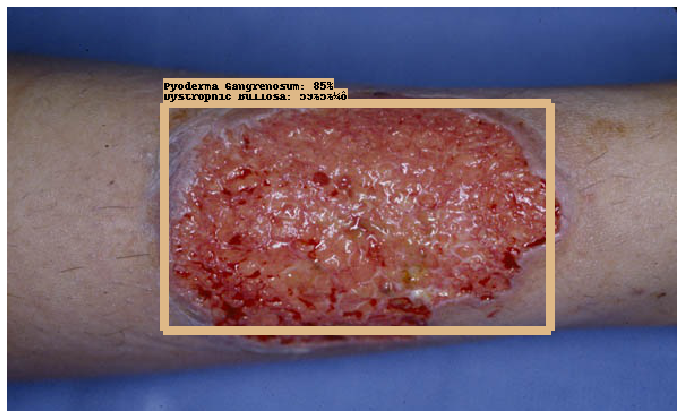

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops

# This is needed since the notebook is stored in the object_detection folder.
# sys.path.append("..")



# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict
for image_path in TEST_IMAGE_PATHS[2:4]:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    
    image_np = load_image_into_numpy_array(image)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.axis("off") #removes axis for image
    plt.imshow(image_np)

In [0]:
cd ~/python3.6/site-packages

[Errno 2] No such file or directory: '/root/python3.6/site-packages'
/root/.local


# Data store and retrive

In [0]:
!pip install -U -q PyDrive

### **Uploade to gdrive**

In [0]:
cd ..

In [0]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os
import sys

In [0]:
zipname = 'Detection'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])
            
print("creating zip file...")
zipfolder(zipname, '/content/Project/')
print("done..")

In [0]:
print("Authenticating......")

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
print("Uploading...")

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()
print("Done.")

### **Retrive data**

In [0]:
#change zip_id before downolading
#zip_id avilabel in zip file share link from drive
zip_id = '1GHDclUSF6rxOu7LsXzVq7MbhPtr9dzfO'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

In [0]:
print("Authenticating......")

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('Project'):
    os.makedirs('Project')
    
print("done..")

Authenticating......
done..


In [0]:
# 2. Download Zip
print ("Downloading zip file....")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('Project.zip')

In [0]:
# 3. Unzip
print ("Uncompressing zip file....")
zip_ref = zipfile.ZipFile('Project.zip', 'r')
zip_ref.extractall('Project/')
zip_ref.close()

# Install Bazel

In [0]:
BAZEL_VERSION = '0.24.1'

In [0]:
!wget https://github.com/bazelbuild/bazel/releases/download/{BAZEL_VERSION}/bazel-{BAZEL_VERSION}-installer-linux-x86_64.sh

In [0]:
!chmod +x bazel-{BAZEL_VERSION}-installer-linux-x86_64.sh

In [0]:
!./bazel-{BAZEL_VERSION}-installer-linux-x86_64.sh

In [0]:
!export PATH="$PATH:$HOME/bin:/root/bin"

In [0]:
!bazel run

In [0]:
!pip list

In [0]:
!pip install tensorflow-gpu==1.15.0  # stable

!pip install tf-nightly      # preview

In [0]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

follow the remianing steps from <br>
https://www.tensorflow.org/install/source

# Building bazel

In [0]:
!git clone https://github.com/tensorflow/tensorflow.git

In [0]:
cd tensorflow/

In [0]:
!python ./configure.py

In [0]:
# !bazel build //tensorflow/tools/pip_package:build_pip_package

In [0]:
!bazel build //tensorflow/lite/toco:toco --verbose_failures

converting to tflite

In [0]:
!bazel run //tensorflow/lite/python:tflite_convert -- \
  --saved_model_dir=/content/Project/fine_tuned_model \
  --output_file=/content/Project/fine_tuned_model/mobilenet.tflite

In [0]:
!./bazel-bin/tensorflow/lite/toco/toco --input_file=/content/Project/fine_tuned_model/frozen_inference_graph.pb --input_formate=TENSORFLOW_GRAPHDEF --output_format=TFLITE --output_file=/content/Project/fine_tuned_model/desease.tflite --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess' --input_shapes=1,224,224,3

In [0]:
!toco --saved_model_dir /content/Project/tflite/tflite_graph.pb \
  --output_file /content/Project/tflite/detect.tflite \
  --input_shapes 1,300,300,3 \
  --input_arrays image_tensor \
  --output_arrays raw_detection_scores \
  --inference_typeQUANTIZED_UINT8 \
  --mean_values=128 \
  --std_values=128 \
  --change_concat_input_ranges=false \
  --allow_custom_ops

In [0]:
!tflite_convert

https://codelabs.developers.google.com/codelabs/tensorflow-for-poets-2-tflite/#2